In [19]:
from top2vec import Top2Vec
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import from_networkx
import torch
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import GCNConv


The duration 1 to 2 is done!
The duration 2 to 3 is done!
The duration 3 to 4 is done!
The duration 4 to 5 is done!
The duration 5 to 6 is done!
The duration 6 to 7 is done!
The duration 7 to 8 is done!
The duration 8 to 9 is done!
The duration 9 to 10 is done!
The duration 10 to 11 is done!
The duration 11 to 12 is done!
The duration 12 to 13 is done!
The duration 13 to 14 is done!
The duration 14 to 15 is done!
The duration 15 to 16 is done!
The duration 16 to 17 is done!
The duration 17 to 18 is done!
The duration 18 to 19 is done!
The duration 19 to 20 is done!


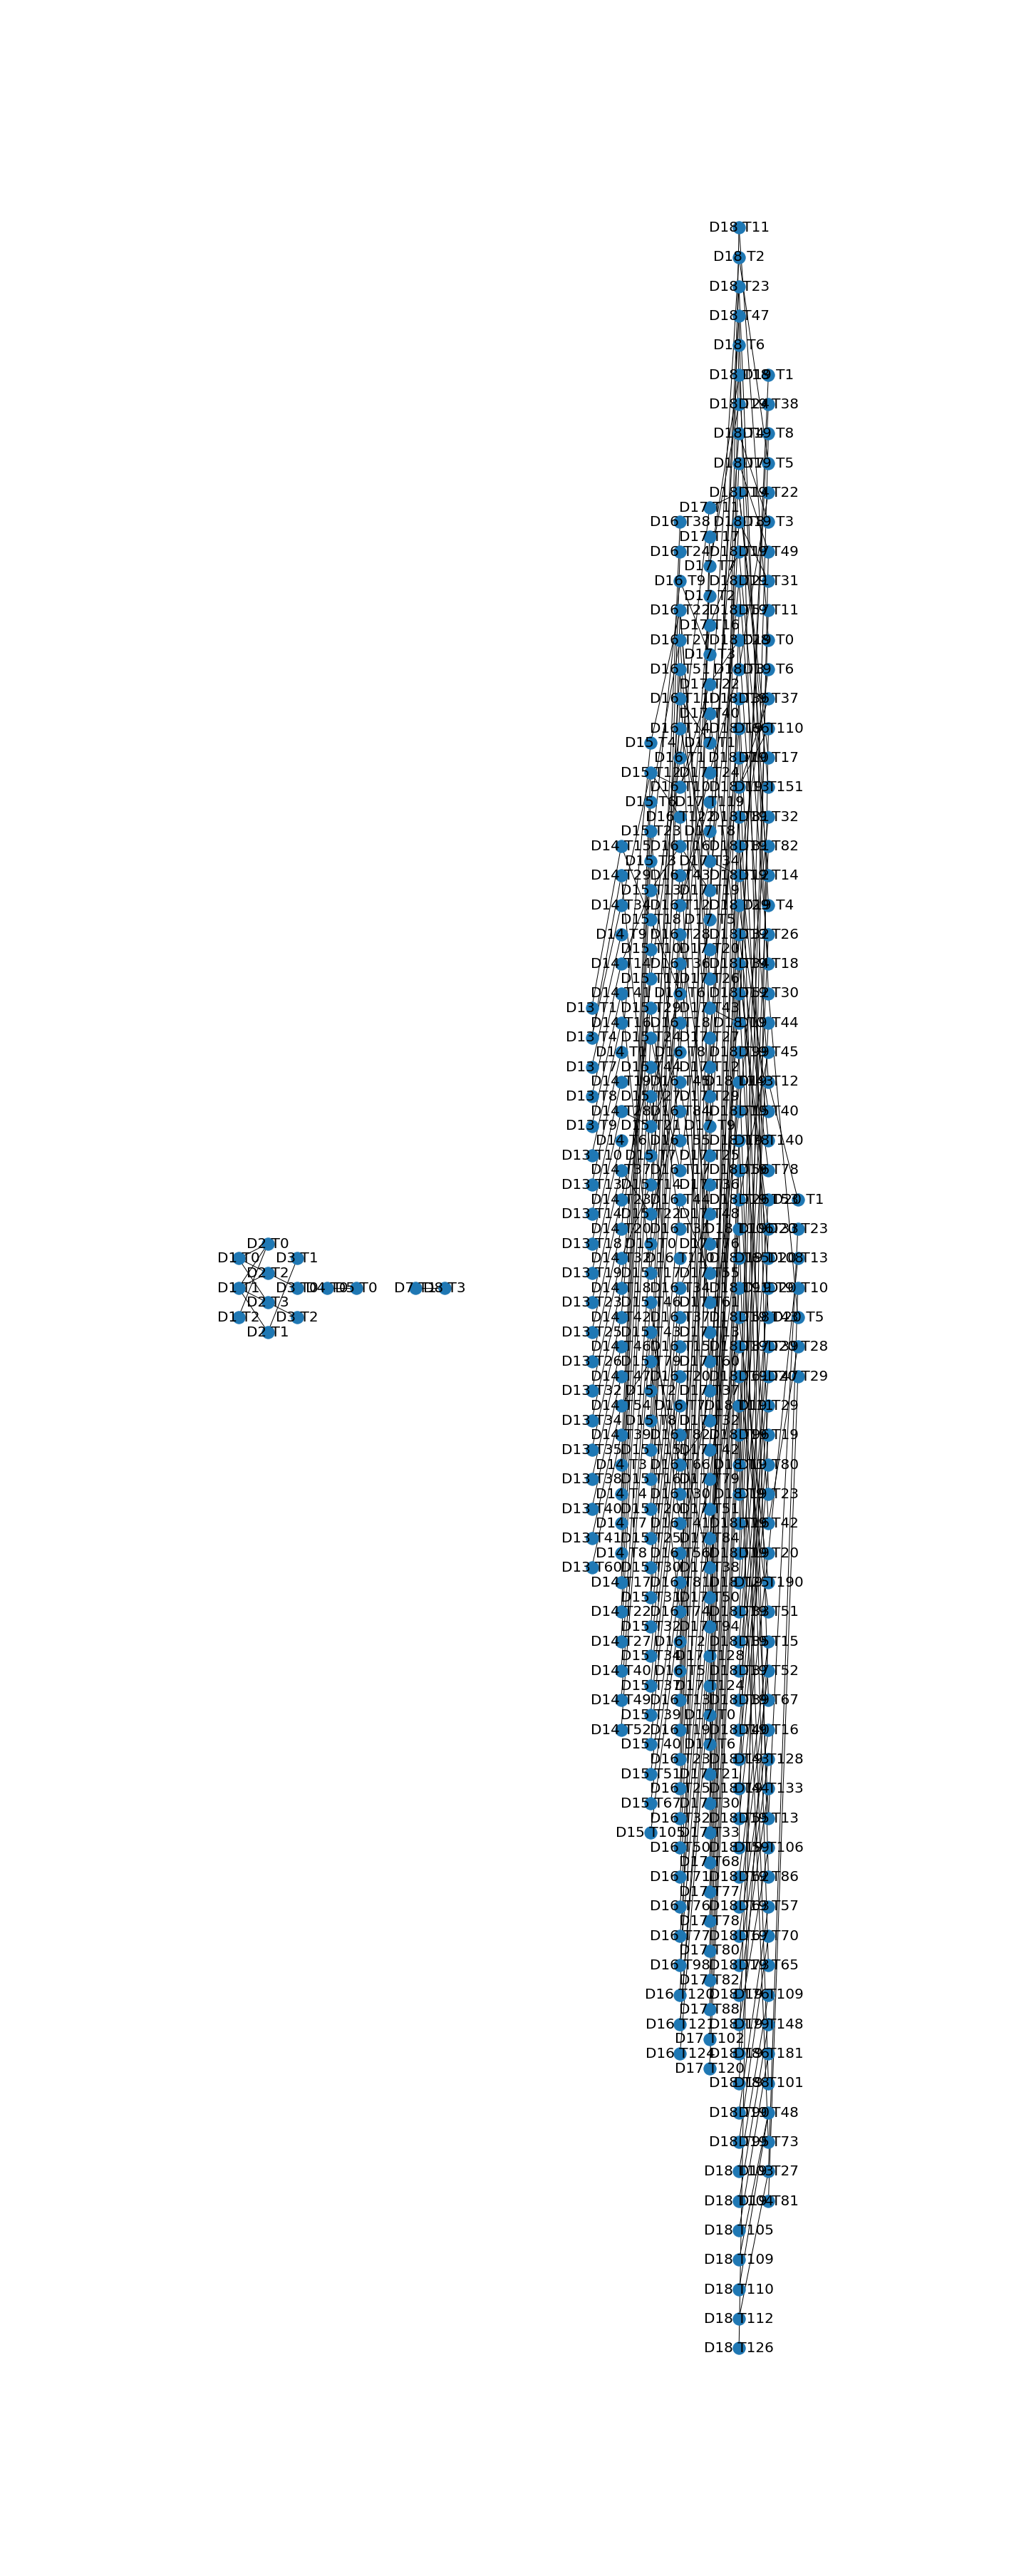

In [20]:
## READ TOP2VEC MODELs AND GENERATE THE EVOLUTION GRAPH USING WEIGHTED JACCARD SIMILARITY

def weighted_jaccard(T1,T2,WT1,WT2):
    intersection_items=np.intersect1d(T1,T2)
    union_items=np.union1d(T1,T2)
    min_value= []
    max_value = []
    for term in intersection_items:
        min_value.append(min(WT1[int(np.where(T1 == term)[0])], WT2[int(np.where(T2 == term)[0])]))
    for term in union_items:
        if (term in T1) and (term in T2):
            max_value.append(max(WT1[int(np.where(T1 == term)[0])], WT2[int(np.where(T2 == term)[0])]))
        elif term in T1: max_value.append(WT1[int(np.where(T1 == term)[0])])
        else: max_value.append(WT2[int(np.where(T2 == term)[0])])
    return sum(min_value)/sum(max_value)

G = nx.Graph()

for d in range(1,20):
    addr1="Topic-Model-arxiv-deep"+str(d)
    addr2= "Topic-Model-arxiv-deep" + str(d+1)
    model1= Top2Vec.load(addr1)
    model2=Top2Vec.load(addr2)
    topic_words1, word_scores1, topic_nums1 = model1.get_topics(model1.get_num_topics())
    topic_words2, word_scores2, topic_nums2 = model2.get_topics(model2.get_num_topics())
    for i in topic_nums1:
        for j in topic_nums2:
            similarity = weighted_jaccard(topic_words1[i], topic_words2[j], word_scores1[i], word_scores2[j])
            if 0.3 < similarity < 1:
                node1="D"+str(d)+" T"+str(i)     #+topic_words1[i][0]+"/"+topic_words1[i][1]+"/"+topic_words1[i][2]+"/..."
                node2="D"+str(d+1)+" T"+str(j)   #+topic_words2[j][0]+"/"+topic_words2[j][1]+"/"+topic_words2[j][2]+"/..."
                G.add_node(node1, layer=d,x=word_scores1[i],y=np.amax(word_scores1[i]))
                G.add_node(node2, layer=d+1,x=word_scores2[j],y=np.amax(word_scores2[j]))
                G.add_edge(node1, node2, edge_attr=similarity)
    print("The duration "+str(d)+ " to " +str(d+1)+" is done!")

layers = [range(1, 21)]
pos = nx.multipartite_layout(G, subset_key="layer")
plt.figure(figsize=(20, 50))
nx.draw(G, pos, with_labels=False)
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
plt.axis("equal")
plt.show()

In [42]:
data=from_networkx(G)
print(data)
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)
print(data)

Data(x=[353, 50], edge_index=[2, 518], edge_attr=[518], y=[353], layer=[353])
Data(x=[353, 50], layer=[353], val_pos_edge_index=[2, 12], val_pos_edge_attr=[12], test_pos_edge_index=[2, 25], test_pos_edge_attr=[25], train_pos_edge_index=[2, 444], train_pos_edge_attr=[444], train_neg_adj_mask=[353, 353], val_neg_edge_index=[2, 12], test_neg_edge_index=[2, 25])


/Users/hamed/Documents/PhD/topicModelling/venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [43]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_features, 128)
        self.conv2 = GCNConv(128, 64)

    def encode(self):
        x = self.conv1(data.x, data.train_pos_edge_index) # convolution 1
        x = x.relu()
        return self.conv2(x, data.train_pos_edge_index) # convolution 2

    def decode(self, z, pos_edge_index, neg_edge_index): # only pos and neg edges
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=-1) # concatenate pos and neg edges
        logits = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)  # dot product
        return logits

    def decode_all(self, z):
        prob_adj = z @ z.t() # get adj NxN
        return (prob_adj > 0).nonzero(as_tuple=False).t() # get predicted edge_list

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [45]:
def get_link_labels(pos_edge_index, neg_edge_index):
    # returns a tensor:
    # [1,1,1,1,...,0,0,0,0,0,..] with the number of ones is equel to the lenght of pos_edge_index
    # and the number of zeros is equal to the length of neg_edge_index
    E = pos_edge_index.size(1) + neg_edge_index.size(1)
    link_labels = torch.zeros(E, dtype=torch.float, device=device)
    link_labels[:pos_edge_index.size(1)] = 1.
    return link_labels


def train():
    model.train()

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index, #positive edges
        num_nodes=data.num_nodes, # number of nodes
        num_neg_samples=data.train_pos_edge_index.size(1)) # number of neg_sample equal to number of pos_edges

    optimizer.zero_grad()

    z = model.encode() #encode
    link_logits = model.decode(z, data.train_pos_edge_index, neg_edge_index) # decode

    link_labels = get_link_labels(data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss


@torch.no_grad()
def test():
    model.eval()
    perfs = []
    for prefix in ["val", "test"]:
        pos_edge_index = data[f'{prefix}_pos_edge_index']
        neg_edge_index = data[f'{prefix}_neg_edge_index']

        z = model.encode() # encode train
        link_logits = model.decode(z, pos_edge_index, neg_edge_index) # decode test or val
        link_probs = link_logits.sigmoid() # apply sigmoid

        link_labels = get_link_labels(pos_edge_index, neg_edge_index) # get link

        perfs.append(roc_auc_score(link_labels.cpu(), link_probs.cpu())) #compute roc_auc score
    return perfs

In [46]:
best_val_perf = test_perf = 0
for epoch in range(1, 201):
    train_loss = train()
    val_perf, tmp_test_perf = test()
    if val_perf > best_val_perf:
        best_val_perf = val_perf
        test_perf = tmp_test_perf
    log = 'Epoch: {:03d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    if epoch % 10 == 0:
        print(log.format(epoch, train_loss, best_val_perf, test_perf))


z = model.encode()
final_edge_index = model.decode_all(z)

Epoch: 010, Loss: 0.6886, Val: 0.5625, Test: 0.4864
Epoch: 020, Loss: 0.6843, Val: 0.6042, Test: 0.5216
Epoch: 030, Loss: 0.6783, Val: 0.7222, Test: 0.5840
Epoch: 040, Loss: 0.6719, Val: 0.8333, Test: 0.8304
Epoch: 050, Loss: 0.6632, Val: 0.8333, Test: 0.8304
Epoch: 060, Loss: 0.6634, Val: 0.8333, Test: 0.8304
Epoch: 070, Loss: 0.6519, Val: 0.8333, Test: 0.8304
Epoch: 080, Loss: 0.6406, Val: 0.8333, Test: 0.8304
Epoch: 090, Loss: 0.6255, Val: 0.8333, Test: 0.8304
Epoch: 100, Loss: 0.6393, Val: 0.8333, Test: 0.8304
Epoch: 110, Loss: 0.6439, Val: 0.8333, Test: 0.8304
Epoch: 120, Loss: 0.6323, Val: 0.8333, Test: 0.8304
Epoch: 130, Loss: 0.6249, Val: 0.8333, Test: 0.8304
Epoch: 140, Loss: 0.6333, Val: 0.8333, Test: 0.8304
Epoch: 150, Loss: 0.6670, Val: 0.8333, Test: 0.8304
Epoch: 160, Loss: 0.6519, Val: 0.8333, Test: 0.8304
Epoch: 170, Loss: 0.6164, Val: 0.8333, Test: 0.8304
Epoch: 180, Loss: 0.6274, Val: 0.8333, Test: 0.8304
Epoch: 190, Loss: 0.6467, Val: 0.8333, Test: 0.8304
Epoch: 200, 